In [2]:
!pip install seaborn

In [3]:
import pandas as pd
import numpy as np
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/waze_dataset.csv", index_col=0)

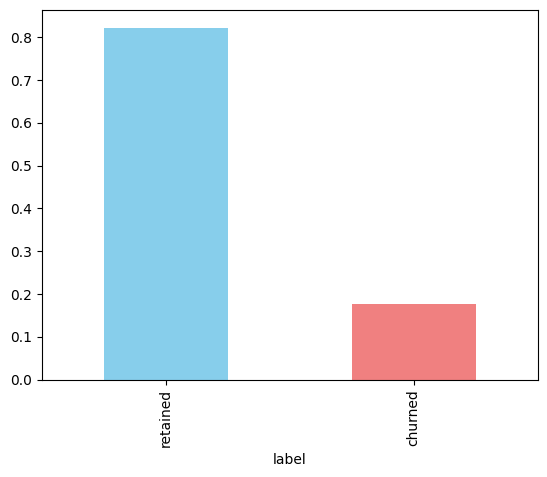

In [7]:
# Target 분포 확인
data['label'].value_counts(normalize = True).plot(kind = 'bar', color = ['skyblue', 'lightcoral']);

In [4]:
# DataLoad 함수

# %%writefile dataloader.py

import pandas as pd

def load_dataset():
    data = pd.read_csv('data/preprocessed.csv')
    data.columns = data.columns.str.lower()
    data = data.drop(data.columns[0], axis=1)
    X = data.drop(columns='label')
    y = data['label']
    
    return X, y

In [5]:
X, y = load_dataset()
print(X.head()) 
print(y.head())

   sessions  drives  total_sessions  n_days_after_onboarding  \
0       283     226      296.748273                     2276   
1       133     107      326.896596                     1225   
2       114      95      135.522926                     2651   
3        49      40       67.589221                       15   
4        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days  device_android  \
0              1985.775061             28            19            True   
1              3160.472914            

In [12]:
# !pip install dataloader

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dataloader: filename=dataloader-2.0-py3-none-any.whl size=10091 sha256=f9ebb85f53913ada5192621d409720ea1ca2886a6d3b896158d9484b615a8d7c
  Stored in directory: c:\users\playdata\appdata\local\pip\cache\wheels\fa\17\c3\e258aa863dd515a9b5759c01f4af55b2a2ea0881b2778fc749
Successfully built dataloader


In [7]:
# dataset 준비
from sklearn.model_selection import train_test_split

# X, y 분리
X, y = load_dataset()

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [8]:
# Baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("KNN", KNeighborsClassifier()),
    ("XGB", XGBClassifier(random_state=0))
]

In [9]:
# 학습

baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

Training LR...
Training GBM...
Training RF...
Training KNN...
Training XGB...


In [10]:
# result

pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LR,GBM,RF,KNN,XGB
accuracy,0.828322,0.824476,0.821678,0.801748,0.811189
precision,0.836831,0.834962,0.835213,0.826389,0.838625
recall,0.983000,0.980450,0.975776,0.960901,0.954101
f1,0.904045,0.901876,0.900039,0.888583,0.892644
roc-auc,0.758722,0.752880,0.732124,0.530733,0.709396


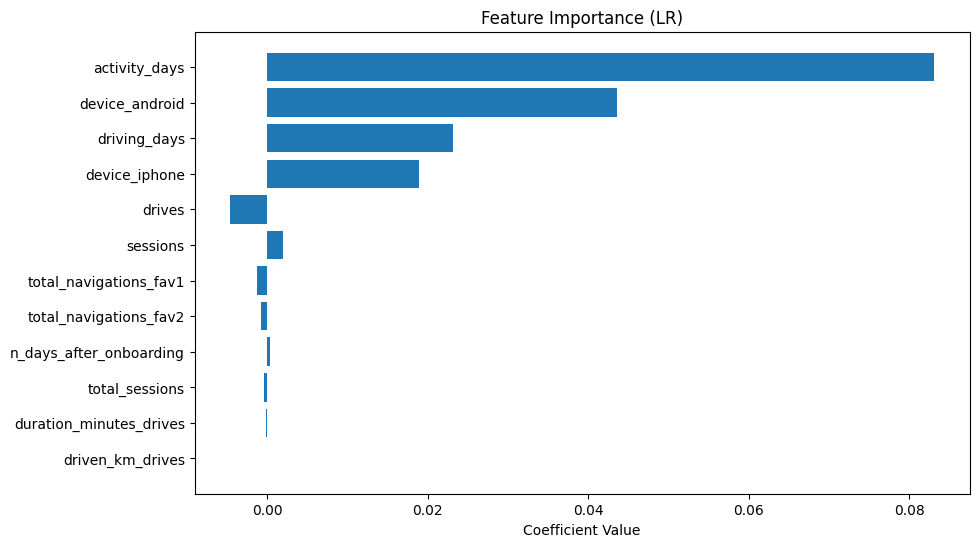

In [12]:
# LR feature importance
import matplotlib.pyplot as plt
import numpy as np

model_lr = LogisticRegression(random_state=0, max_iter=3000)

model_lr.fit(X_train, y_train)

# coefficient

coefficients = model_lr.coef_[0]
indices = np.argsort(np.abs(coefficients))  
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (LR)")
plt.barh(range(len(indices)), coefficients[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Coefficient Value")
plt.show()